In [1]:
from pandas_datareader import data as pdr
from yahoo_fin import stock_info as si
import yfinance as yf
import pandas as pd
import datetime
import time
import talib
from talib import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost as xgb
import math
import numpy as np
from sklearn.decomposition import PCA
import pickle
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'
yf.pdr_override()

In [2]:
from LSSVMRegression import LSSVMRegression

In [3]:
def add_indicators():
        
    R_S_I = RSI(df['Adj Close'], timeperiod=slow)
    E_M_A = EMA(df['Adj Close'], timeperiod=fast)
    macd, macdsig, macdhist = MACD(df['Adj Close'], fastperiod=fast, slowperiod=slow, signalperiod=really_fast)
    mfi = MFI(df['High'], df['Low'], df['Adj Close'],df['Volume'],timeperiod=fast)
    slowk, slowd = STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=fast, slowk_period=slow, slowk_matype=0, slowd_period=slow, slowd_matype=0)
    
    #
    #
    #
    
    df['ema'] = E_M_A
    df['rsi'] = R_S_I
    df['macd'] = macd
    df['macdsig'] = macdsig
    df['macdhist'] = macdhist
    df['mfi'] = mfi
    df['slowK'] = slowk
    df['slowD'] = slowd
    
    
    
    ####
    
    

    #76 vars

    #are_all_zero = (test_TA == 0).all()
    #true if all values are 0
    #false if contain a non 0'''

    df.drop(['Close'], axis =1, inplace = True)

    

In [4]:
def add_lag(num_lag_cols, this_df):
    
    tic = time.perf_counter()
    
    '''df['ema'] = E_M_A
    df['rsi'] = R_S_I
    df['macd'] = macd
    df['macdsig'] = macdsig
    df['macdhist'] = macdhist
    df['mfi'] = mfi
    df['slowK'] = slowk
    df['slowD'] = slowd'''
    
    lag_cols = ['open',
                 'high',
                 'low',
                 'adj_close',
                 'volume',
                 'ema',
                 'rsi',
                 'macd',
                 'macdsig',
                 'macdhist',
                 'mfi',
                 'slowk',
                 'slowd']

    shift_range = [x+1 for x in range(num_lag_cols)]

    for shift in shift_range:
        train_shift = this_df[merging_keys + lag_cols].copy()

        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift

        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        this_df = pd.merge(this_df, train_shift, on=merging_keys, how='left') #.fillna(0)

    del train_shift
    
    toc = time.perf_counter()

    tic_toc = (toc - tic) / 60

    print(f"completed lagging in {tic_toc:0.4f} min")
    

    return this_df

In [140]:
def add_scale(num_interval_lag):

    cols_to_scale = ['open',#
                     'high',#
                     'low',#
                     #'adj_close',#
                     'volume',#
                     'ema',#
                     'rsi',#
                     'macd',#
                     'macdsig',#
                     'macdhist',#
                     'mfi',#
                     'slowk',#
                     'slowd']#
                    

    for i in range(1,num_interval_lag+1):
        cols_to_scale.append("ema_lag_"+str(i))
        cols_to_scale.append("slowk_lag_"+str(i))
        cols_to_scale.append("slowd_lag_"+str(i))
        cols_to_scale.append("rsi_lag_"+str(i))

        cols_to_scale.append("volume_lag_"+str(i))

        cols_to_scale.append("adj_close_lag_"+str(i))
        
        cols_to_scale.append("open_lag_"+str(i))
        cols_to_scale.append("high_lag_"+str(i))
        cols_to_scale.append("low_lag_"+str(i))

        cols_to_scale.append("macd_lag_"+str(i))
        cols_to_scale.append("macdsig_lag_"+str(i))
        cols_to_scale.append("macdhist_lag_"+str(i))

        cols_to_scale.append("mfi_lag_"+str(i))
      
    return cols_to_scale

In [141]:
stock = 'T'

start_date = datetime.datetime.now() - datetime.timedelta(days=59)

end_date = datetime.datetime.now()

df = pdr.get_data_yahoo(stock, start=start_date, end=end_date, interval = "2m", prepost = True)

#df = pdr.get_data_yahoo(stock, period = "max", interval = "1d", prepost = True)

#df.index = df.index.tz_localize(None)

'''#2 min ticker
# 30 intervals = 1 hour << OLD
# 195 intervals = trading day'''
                                            # there are more intervals that we can use / change
really_fast = 30
fast = 60
slow = 90

add_indicators()

# Convert Date column to datetime
df.reset_index(level=0, inplace=True)

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

df['order_day'] = [x for x in list(range(len(df)))]
# merging_keys


# Get difference between high and low of each day

[*********************100%***********************]  1 of 1 completed


In [142]:
col_list = df.columns.to_list()
col_list.remove('datetime')

In [143]:
col_list

['open',
 'high',
 'low',
 'adj_close',
 'volume',
 'ema',
 'rsi',
 'macd',
 'macdsig',
 'macdhist',
 'mfi',
 'slowk',
 'slowd',
 'order_day']

In [144]:
merging_keys = ['order_day']

num_interval_lag = 30

df = add_lag(num_interval_lag, df)

#df['adj_close'] = df['adj_close'].shift(30)

completed lagging in 0.0267 min


In [145]:
print(df.shape)

(14103, 405)


In [146]:
print(df.head(40))

                    datetime   open   high     low  adj_close  volume  ema  \
0  2021-01-08 09:30:00-05:00    NaN    NaN     NaN        NaN     NaN  NaN   
1  2021-01-13 19:00:00-05:00  28.58  28.60  28.580     28.600     0.0  NaN   
2  2021-01-13 19:02:00-05:00  28.61  28.61  28.600     28.600     0.0  NaN   
3  2021-01-13 19:04:00-05:00  28.61  28.61  28.600     28.600     0.0  NaN   
4  2021-01-13 19:06:00-05:00  28.60  28.60  28.600     28.600     0.0  NaN   
5  2021-01-13 19:08:00-05:00  28.60  28.60  28.580     28.600     0.0  NaN   
6  2021-01-13 19:10:00-05:00  28.60  28.60  28.600     28.600     0.0  NaN   
7  2021-01-13 19:14:00-05:00  28.58  28.60  28.580     28.590     0.0  NaN   
8  2021-01-13 19:16:00-05:00  28.59  28.60  28.580     28.600     0.0  NaN   
9  2021-01-13 19:18:00-05:00  28.60  28.60  28.600     28.600     0.0  NaN   
10 2021-01-13 19:20:00-05:00  28.60  28.60  28.600     28.600     0.0  NaN   
11 2021-01-13 19:22:00-05:00  28.61  28.61  28.600     28.600   

In [147]:
window_size = 30

df['adj_close'] = df['adj_close'].shift(-window_size)



In [148]:
cols_to_rem = ['open',
                 'high',
                 'low',
                 'volume',
                 'ema',
                 'rsi',
                 'macd',
                 'macdsig',
                 'macdhist',
                 'mfi',
                 'slowk',
                 'slowd',
                 'order_day']

In [149]:
close_vals_list = df['adj_close']

In [150]:
df.drop(cols_to_rem, axis = 1, inplace = True)

In [151]:
print(df.tail(40))

                       datetime  adj_close  open_lag_1  high_lag_1  low_lag_1  \
14063 2021-03-03 18:38:00-05:00      28.67       28.71       28.72      28.71   
14064 2021-03-03 18:40:00-05:00      28.68       28.72       28.72      28.72   
14065 2021-03-03 18:42:00-05:00      28.68       28.72       28.72      28.72   
14066 2021-03-03 18:44:00-05:00      28.68       28.71       28.72      28.71   
14067 2021-03-03 18:46:00-05:00      28.67       28.72       28.72      28.71   
14068 2021-03-03 18:48:00-05:00      28.67       28.70       28.70      28.70   
14069 2021-03-03 18:50:00-05:00      28.67       28.71       28.71      28.71   
14070 2021-03-03 18:52:00-05:00      28.71       28.71       28.71      28.70   
14071 2021-03-03 18:54:00-05:00      28.69       28.71       28.71      28.71   
14072 2021-03-03 18:56:00-05:00      28.67       28.70       28.70      28.70   
14073 2021-03-03 18:58:00-05:00        NaN       28.71       28.71      28.71   
14074 2021-03-03 19:00:00-05

In [152]:


#close_vals_list = df['adj_close']

df.fillna(0, inplace=True)

#df.fillna(0, inplace=True)

#BUY => 1, SELL => 0, HOLD => 2

num_test = int(.10*len(df))
num_train = len(df) - num_test

# Split into train, cv, and test
train = df[:num_train]
test = df[num_train:]

#print(test['datetime'].iloc[[-1]])
#print(test['test_labels'].iloc[[-1]])

train_close_vals = close_vals_list[:num_train]
test_close_vals = close_vals_list[num_train:]

#test_dates_list = test['date']
#BUY => 1, SELL => 0, HOLD => 2

In [153]:
test_dates_list = test['datetime']

In [154]:
train_dates_list = train['datetime']

In [155]:
test_adj_close_list = close_vals_list[num_train:]

In [156]:
cols_to_scale = add_scale(num_interval_lag)
#cols_to_scale.remove(cols_to_rem)

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak


In [157]:
for element in cols_to_rem:

    if element in cols_to_scale:

        cols_to_scale.remove(element)

In [158]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import normalize

In [159]:

# Convert the numpy array back into pandas dataframe

#train_scaled_3, norms = normalize(train[cols_to_scale], return_norm=True)

In [160]:
#train_scaled_3 = pd.DataFrame(train_scaled_3, columns=cols_to_scale)


In [161]:
#scaler_2 = Normalizer()

#scaler_2.fit(train[cols_to_scale])
#train_scaled_2 = scaler_2.transform(train[cols_to_scale])

# Convert the numpy array back into pandas dataframe

#train_scaled_2 = pd.DataFrame(train_scaled_2, columns=cols_to_scale)

In [162]:
train_scaled['open_lag_1']

90       0.082266
91       0.081755
92       0.081375
93       0.080804
94       0.080146
           ...   
11869    0.000064
11870    0.000064
11871    0.000064
11872    0.000063
11873    0.000063
Name: open_lag_1, Length: 11784, dtype: float64

In [163]:
#train_scaled_2['open_lag_1']

In [164]:
#train_scaled_3['open_lag_1']

In [165]:
#de_normed = train_scaled_3['open_lag_1'] * norms

In [166]:
#de_normed

In [167]:
train['open_lag_1']

0         0.00
1         0.00
2        28.58
3        28.61
4        28.61
         ...  
12688    28.02
12689    28.03
12690    28.04
12691    28.04
12692    28.04
Name: open_lag_1, Length: 12693, dtype: float64

In [168]:
#scaler = StandardScaler()

scaler = StandardScaler()

scaler.fit(train[cols_to_scale])
train_scaled = scaler.transform(train[cols_to_scale])

# Convert the numpy array back into pandas dataframe

train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)

train_scaled = train_scaled[slow:]
train = train[slow:]

#scaling test dataset

#scaler_2 = StandardScaler()

#scaler_2  = MinMaxScaler(feature_range=(-1,1))
#scaler.fit(test[cols_to_scale])
test_scaled = scaler.transform(test[cols_to_scale])

# Convert the numpy array back into pandas dataframe

test_scaled = pd.DataFrame(test_scaled, columns=cols_to_scale)

features = cols_to_scale

In [169]:
features

['ema_lag_1',
 'slowk_lag_1',
 'slowd_lag_1',
 'rsi_lag_1',
 'volume_lag_1',
 'adj_close_lag_1',
 'open_lag_1',
 'high_lag_1',
 'low_lag_1',
 'macd_lag_1',
 'macdsig_lag_1',
 'macdhist_lag_1',
 'mfi_lag_1',
 'ema_lag_2',
 'slowk_lag_2',
 'slowd_lag_2',
 'rsi_lag_2',
 'volume_lag_2',
 'adj_close_lag_2',
 'open_lag_2',
 'high_lag_2',
 'low_lag_2',
 'macd_lag_2',
 'macdsig_lag_2',
 'macdhist_lag_2',
 'mfi_lag_2',
 'ema_lag_3',
 'slowk_lag_3',
 'slowd_lag_3',
 'rsi_lag_3',
 'volume_lag_3',
 'adj_close_lag_3',
 'open_lag_3',
 'high_lag_3',
 'low_lag_3',
 'macd_lag_3',
 'macdsig_lag_3',
 'macdhist_lag_3',
 'mfi_lag_3',
 'ema_lag_4',
 'slowk_lag_4',
 'slowd_lag_4',
 'rsi_lag_4',
 'volume_lag_4',
 'adj_close_lag_4',
 'open_lag_4',
 'high_lag_4',
 'low_lag_4',
 'macd_lag_4',
 'macdsig_lag_4',
 'macdhist_lag_4',
 'mfi_lag_4',
 'ema_lag_5',
 'slowk_lag_5',
 'slowd_lag_5',
 'rsi_lag_5',
 'volume_lag_5',
 'adj_close_lag_5',
 'open_lag_5',
 'high_lag_5',
 'low_lag_5',
 'macd_lag_5',
 'macdsig_lag_5'

In [172]:
#features.remove('adj_close')

In [173]:
print('adj_close' in features)

False


In [174]:
print('adj_close' in train_scaled.columns)

False


In [176]:
#features.remove(target)

# Split into X and y
'''X_train_scaled = train_scaled[features]
y_train_scaled = train['labels']

X_test_scaled = test_scaled[features]
y_test_scaled = test['labels']'''

X_train = train_scaled[features]
y_train = train['adj_close']

X_test = test_scaled[features]
y_test = test['adj_close']

In [177]:
X_test

,ema_lag_1,slowk_lag_1,slowd_lag_1,rsi_lag_1,volume_lag_1,adj_close_lag_1,open_lag_1,high_lag_1,low_lag_1,macd_lag_1,...,rsi_lag_30,volume_lag_30,adj_close_lag_30,open_lag_30,high_lag_30,low_lag_30,macd_lag_30,macdsig_lag_30,macdhist_lag_30,mfi_lag_30
0,-0.388603,-1.135833,-1.679669,-0.530961,-0.087217,-1.901011,-1.900623,-1.922128,-1.913281,-0.752932,...,-0.549735,-0.087217,-0.583773,-0.597509,-0.592948,-0.594112,-1.597169,-1.948303,0.717278,2.151992
1,-0.388424,-1.129055,-1.674359,-0.530961,-0.087217,-1.901011,-1.900623,-1.922128,-1.892298,-0.730124,...,-0.549735,-0.087217,-0.583773,-0.583825,-0.592948,-0.580420,-1.558058,-1.929776,0.783777,2.150782
2,-0.388250,-1.125053,-1.669080,-0.530961,-0.087217,-1.901011,-1.900623,-1.922128,-1.871315,-0.708000,...,-0.549735,-0.087217,-0.583773,-0.583825,-0.592948,-0.580420,-1.519918,-1.909826,0.843204,2.149762
3,-0.388083,-1.124714,-1.663891,-0.530961,-0.087217,-1.901011,-1.879677,-1.901269,-1.871315,-0.686539,...,-0.549735,-0.087217,-0.583773,-0.583825,-0.592948,-0.580420,-1.482724,-1.888610,0.896086,2.148595
4,-0.387921,-1.090326,-1.658333,-0.530961,-0.087217,-1.901011,-1.879677,-1.901269,-1.871315,-0.665721,...,-0.549735,-0.087217,-0.583773,-0.583825,-0.592948,-0.580420,-1.446450,-1.866273,0.942915,2.148087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,-0.057381,-0.198496,0.388486,-0.013723,-0.087217,-0.580976,-0.560066,-0.587136,-0.549380,-0.165090,...,0.337775,-0.087217,-0.118524,-0.118594,-0.128121,-0.108034,0.133018,0.261288,-0.345006,-0.997837
1406,-0.057857,-0.220841,0.370791,-0.013723,-0.087217,-0.580976,-0.581012,-0.607995,-0.549380,-0.175592,...,0.260499,-0.087217,-0.125366,-0.118594,-0.128121,-0.114880,0.120200,0.252460,-0.358863,-0.997837
1407,-0.058318,-0.243185,0.352837,-0.013723,-0.087217,-0.580976,-0.581012,-0.524558,-0.549380,-0.185377,...,0.334295,-0.087217,-0.118524,-0.118594,-0.128121,-0.108034,0.113057,0.243712,-0.355550,-0.997837
1408,-0.058115,-0.236226,0.335129,0.349020,-0.087217,-0.497164,-0.497227,-0.524558,-0.528397,-0.174312,...,0.256706,-0.087217,-0.125366,-0.125436,-0.134956,-0.114880,0.101191,0.234713,-0.365997,-0.997837


In [178]:
y_train

90       28.6700
91       28.6600
92       28.6800
93       28.6800
94       28.6800
          ...   
12688    28.0200
12689    28.0400
12690    28.0200
12691    28.0199
12692    28.0100
Name: adj_close, Length: 12603, dtype: float64

In [179]:
import pyswarms as ps

from sklearn.metrics import mean_squared_error

In [180]:
def fitness_function(position):
    
    #print(position)
    
    #svrRegressor = SVR(kernel='rbf', gamma = position[0].all(), C = position[1].all() )
    
    clfrbf=LSSVMRegression(
        gamma=position[0].all(),       #set the gamma-hyper parameter equal to 1
        kernel='rbf', #use the linear kernel
        sigma=position[1].all(),
            )
    
    clfrbf.fit(X_train, y_train)
    
    y_train_pred = clfrbf.predict(X_train)
    
    y_test_pred = clfrbf.predict(X_test)
    
    mse_test =mean_squared_error(y_test, y_test_pred)
    
    rmse_test = math.sqrt(mse_test)
    
    print('Optimizing the Parameters ..... C = {c}, Gamma={gamma}'.format(c=position[1], gamma=position[0]))
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    
    rmse_train = math.sqrt(mse_train)
    
    #list(range(mse_f_train,rmse_f_train))
    retVal= rmse_test #Return a vector instead of single value. you can use the rmse_test and ignore rmse_train
    
    return retVal

In [42]:
lb = [10, 0.0001]
ub = [1000,0.1]
#mb = [100, 0.001]
bounds = (lb,ub)

options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=2,options=options, bounds = bounds)
best_cost, opt_pair = optimizer.optimize(fitness_function, iters=50)

2021-03-03 08:39:08,998 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   2%|█▏                                                           |1/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.33571874e+02 3.58935260e-02], Gamma=[5.51052404e+02 6.37079574e-02]


pyswarms.single.global_best:   4%|██▍                                                          |2/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.37524244e+02 4.37617249e-02], Gamma=[5.51848210e+02 9.90664312e-02]


pyswarms.single.global_best:   6%|███▋                                                         |3/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.40616042e+02 8.44931591e-02], Gamma=[5.52181305e+02 4.20711615e-02]


pyswarms.single.global_best:   8%|████▉                                                        |4/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.40651613e+02 5.12145173e-02], Gamma=[5.52029811e+02 2.94719709e-02]


pyswarms.single.global_best:  10%|██████                                                       |5/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.39467280e+02 5.76052241e-02], Gamma=[5.51276216e+02 6.11282725e-02]


pyswarms.single.global_best:  12%|███████▎                                                     |6/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.37257362e+02 4.97255351e-03], Gamma=[5.50500575e+02 4.13633329e-02]


pyswarms.single.global_best:  14%|████████▌                                                    |7/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.36923580e+02 2.92975039e-02], Gamma=[5.49939453e+02 8.52918121e-02]


pyswarms.single.global_best:  16%|█████████▊                                                   |8/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.38696712e+02 1.80167128e-02], Gamma=[5.49687645e+02 7.68937383e-02]


pyswarms.single.global_best:  18%|██████████▉                                                  |9/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.40496391e+02 7.01459697e-02], Gamma=[5.50255968e+02 2.41137212e-02]


pyswarms.single.global_best:  20%|████████████                                                |10/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.43953200e+02 8.51044814e-02], Gamma=[5.51138501e+02 4.59140096e-02]


pyswarms.single.global_best:  22%|█████████████▏                                              |11/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.43147502e+02 4.81223971e-02], Gamma=[5.51901072e+02 4.45005565e-02]


pyswarms.single.global_best:  24%|██████████████▍                                             |12/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.43516162e+02 8.40926696e-02], Gamma=[5.52385078e+02 2.52698604e-02]


pyswarms.single.global_best:  26%|███████████████▌                                            |13/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.43488952e+02 9.28408429e-02], Gamma=[5.52554636e+02 9.65845205e-02]


pyswarms.single.global_best:  28%|████████████████▊                                           |14/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.41380233e+02 7.04305316e-02], Gamma=[5.52091136e+02 1.56553009e-02]


pyswarms.single.global_best:  30%|██████████████████                                          |15/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.37956964e+02 2.12426831e-02], Gamma=[5.51413409e+02 3.13198480e-02]


pyswarms.single.global_best:  32%|███████████████████▏                                        |16/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.37596949e+02 6.95178605e-02], Gamma=[5.50696819e+02 3.08107697e-02]


pyswarms.single.global_best:  34%|████████████████████▍                                       |17/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.40496113e+02 9.03633018e-02], Gamma=[5.50258905e+02 1.24162542e-02]


pyswarms.single.global_best:  36%|█████████████████████▌                                      |18/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.40294024e+02 9.07595085e-02], Gamma=[5.50090236e+02 9.05315242e-02]


pyswarms.single.global_best:  38%|██████████████████████▊                                     |19/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.3793297e+02 6.6012519e-02], Gamma=[5.50207498e+02 3.24167701e-02]


pyswarms.single.global_best:  40%|████████████████████████                                    |20/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.37157535e+02 2.91805356e-02], Gamma=[5.50515926e+02 6.72623272e-02]


pyswarms.single.global_best:  42%|█████████████████████████▏                                  |21/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.38887859e+02 8.74016552e-02], Gamma=[5.50981137e+02 8.80329524e-02]


pyswarms.single.global_best:  44%|██████████████████████████▍                                 |22/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.41888562e+02 1.62958723e-02], Gamma=[5.51426281e+02 9.13062391e-02]


pyswarms.single.global_best:  46%|███████████████████████████▌                                |23/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.45660210e+02 5.18661399e-02], Gamma=[5.51594919e+02 6.83670503e-02]


pyswarms.single.global_best:  48%|████████████████████████████▊                               |24/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.45160325e+02 8.45699303e-02], Gamma=[5.51420141e+02 3.50127517e-02]


pyswarms.single.global_best:  50%|██████████████████████████████                              |25/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.41477030e+02 9.31759419e-02], Gamma=[5.51157188e+02 9.82210524e-03]


pyswarms.single.global_best:  52%|███████████████████████████████▏                            |26/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.35519864e+02 6.91917075e-02], Gamma=[5.50875377e+02 9.63222477e-02]


pyswarms.single.global_best:  54%|████████████████████████████████▍                           |27/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.32666200e+02 3.78920715e-02], Gamma=[5.50630442e+02 6.57742477e-02]


pyswarms.single.global_best:  56%|█████████████████████████████████▌                          |28/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.30435042e+02 1.01113755e-02], Gamma=[5.50427819e+02 2.77144726e-02]


pyswarms.single.global_best:  58%|██████████████████████████████████▊                         |29/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.29088094e+02 6.76515086e-03], Gamma=[5.50563572e+02 1.80947379e-03]


pyswarms.single.global_best:  60%|████████████████████████████████████                        |30/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.31249639e+02 2.15357478e-02], Gamma=[5.50835096e+02 2.20092403e-03]


pyswarms.single.global_best:  62%|█████████████████████████████████████▏                      |31/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.34511231e+02 3.86152967e-02], Gamma=[5.51145933e+02 7.92800324e-03]


pyswarms.single.global_best:  64%|██████████████████████████████████████▍                     |32/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.40797054e+02 5.31434978e-02], Gamma=[5.51407327e+02 2.02894393e-02]


pyswarms.single.global_best:  66%|███████████████████████████████████████▌                    |33/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.48799780e+02 6.51230594e-02], Gamma=[5.51413480e+02 3.59797829e-02]


pyswarms.single.global_best:  68%|████████████████████████████████████████▊                   |34/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.49328207e+02 6.77067216e-02], Gamma=[5.51341291e+02 5.30712861e-02]


pyswarms.single.global_best:  70%|██████████████████████████████████████████                  |35/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.43945430e+02 6.15072607e-02], Gamma=[5.51089254e+02 6.53544067e-02]


pyswarms.single.global_best:  72%|███████████████████████████████████████████▏                |36/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.36343342e+02 5.55552772e-02], Gamma=[5.50859193e+02 6.52349509e-02]


pyswarms.single.global_best:  74%|████████████████████████████████████████████▍               |37/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.31828505e+02 4.77439938e-02], Gamma=[5.50690340e+02 5.48813813e-02]


pyswarms.single.global_best:  76%|█████████████████████████████████████████████▌              |38/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.29464313e+02 4.10233554e-02], Gamma=[5.50799397e+02 3.82242308e-02]


pyswarms.single.global_best:  78%|██████████████████████████████████████████████▊             |39/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.28519620e+02 3.77000864e-02], Gamma=[5.50942137e+02 2.80775769e-02]


pyswarms.single.global_best:  78%|██████████████████████████████████████████████▊             |39/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.33633927e+02 3.51150999e-02], Gamma=[5.51130992e+02 1.91838937e-02]


pyswarms.single.global_best:  82%|█████████████████████████████████████████████████▏          |41/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.42660611e+02 3.46979467e-02], Gamma=[5.51265179e+02 2.36452356e-02]


pyswarms.single.global_best:  84%|██████████████████████████████████████████████████▍         |42/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.52185270e+02 3.71563736e-02], Gamma=[5.51312510e+02 3.53726662e-02]


pyswarms.single.global_best:  86%|███████████████████████████████████████████████████▌        |43/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.58449287e+02 4.36233801e-02], Gamma=[5.5123105e+02 5.7825472e-02]


pyswarms.single.global_best:  88%|████████████████████████████████████████████████████▊       |44/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.51307030e+02 5.10866977e-02], Gamma=[5.51084046e+02 6.91988901e-02]


pyswarms.single.global_best:  90%|██████████████████████████████████████████████████████      |45/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.36274474e+02 5.43492312e-02], Gamma=[5.50945129e+02 6.75392927e-02]


pyswarms.single.global_best:  92%|███████████████████████████████████████████████████████▏    |46/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.24389156e+02 5.82491343e-02], Gamma=[5.50854082e+02 5.48313076e-02]


pyswarms.single.global_best:  94%|████████████████████████████████████████████████████████▍   |47/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.16425564e+02 5.30228652e-02], Gamma=[5.50852669e+02 3.62311464e-02]


pyswarms.single.global_best:  96%|█████████████████████████████████████████████████████████▌  |48/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.20851614e+02 4.29229446e-02], Gamma=[5.50961772e+02 1.92134074e-02]


pyswarms.single.global_best:  98%|██████████████████████████████████████████████████████████▊ |49/50, best_cost=0.00866

Optimizing the Parameters ..... C = [5.32586116e+02 3.53052011e-02], Gamma=[5.51074543e+02 1.46003068e-03]


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|50/50, best_cost=0.00866
2021-03-03 18:24:10,035 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.008659208964108704, best pos: [5.51052404e+02 6.37079574e-02]


Optimizing the Parameters ..... C = [5.43899511e+02 2.93180733e-02], Gamma=[5.51163378e+02 1.23338052e-03]


In [44]:
print(best_cost)
print(opt_pair)

0.008659208964108704
[5.51052404e+02 6.37079574e-02]


In [68]:
test_close_vals.describe()


count    1259.000000
mean       48.387212
std         0.504768
min        46.320000
25%        48.100000
50%        48.320000
75%        48.655001
max        49.610001
Name: adj_close, dtype: float64

In [69]:
pd.DataFrame(de_normed_y_hat).describe()

,0
count,1289.000000
mean,515.564693
std,637.940149
min,-433.897682
25%,46.529978
50%,357.172018
75%,638.762413
max,2649.619707


In [112]:
clfrbf=LSSVMRegression(
        gamma=opt_pair[0],       #set the gamma-hyper parameter equal to 1
        kernel='rbf', #use the linear kernel
        sigma=opt_pair[1]
            )

In [113]:
clfrbf.fit(X_train, y_train)

In [186]:
clfrbf.get_params()

{'c': 1.0,
 'd': 2,
 'gamma': 551.0524037784046,
 'kernel': 'rbf',
 'sigma': 0.06370795742106614}

In [190]:
print(*clfrbf.coef_)

0.0656196405922152 0.0498915595032276 0.048702989953007855 0.04782558390349771 0.04733978372337578 0.04654525963788912 0.045890403601651246 0.04547325417717731 0.044687670028005534 0.04404089926070167 0.04320697999342522 0.04227013979720748 0.042223030411057995 0.041293726653363796 0.040638761237093896 0.040124901369906645 0.0397433265519202 0.04009245908243798 0.03886031261110132 0.03827903441853777 0.03788454617827358 0.03746142046532421 0.03682468993246939 0.03650671754222172 0.035791847095612776 0.05301522169618938 -0.011599548724924035 -0.012700482250749592 0.0014964873346050562 -0.0014242999641169544 -0.0015351929852992334 -0.0016962456175942608 -0.0015272970806384937 -0.0017620930975728278 -0.0018146357276664763 -0.0019049583067905977 -0.0020448258268160073 -0.002090998809503773 -0.0021427861681791176 -0.002162579309678422 -0.0021686581359974884 -0.0021966071798807164 -0.0021972201464088865 -0.002199732572729206 -0.002200397163394062 -0.002204150133275048 -0.0022050264308918583 

-0.002182903422871122 -0.0021838827032325 -0.0021838522942510255 -0.0021832609240846125 -0.0021827248322802183 -0.0021823093696565596 -0.002181661693536699 -0.0021810107234539054 -0.0021800514602636906 -0.0021801325812430493 -0.002179248891084823 -0.0021765855729873962 -0.002174741883316167 -0.0021536533384507763 -0.002149749823044304 -0.0021454753759040947 -0.0021373615271403526 -0.002136434704662534 -0.0021361447503930875 -0.0021333910982956595 -0.0021335745821617056 -0.0021336887949602395 -0.002133951804867499 -0.0021278847317141 -0.0021291807288802518 -0.0021300564684039614 -0.002132394507999302 -0.002131995274535344 -0.002131819172255657 -0.0021322944508940407 -0.0021305723282208 -0.002125870965285024 -0.0021252838930624816 -0.002120977412525446 -0.0021173592950424615 -0.0021162852979468875 -0.002118397584765896 -0.0021178947506424657 -0.0021166158073737725 -0.002104332023522782 -0.002102887533884644 -0.0020967667338120423 -0.002097294415571443 -0.0020980584608975357 -0.0021015822

 -0.009711752200233272 -0.01965087132690763 0.0037493953243769545 0.017178533313555757 0.03372623084796947 0.014856491139418736 0.010823218255618227 -0.0013711708740531384 -0.02749389862720458 -0.03192035201081451 -0.006139889844936795 0.0022973282701289543 0.025135502274504926 0.02228534726675237 0.01968083409183831 0.00903126800895811 0.018158130333642955 0.01932361547837347 0.012110961469667659 -0.017579962123073525 -0.015791339476017956 -0.007088993094585756 -0.010841171637394557 -0.032281493423980644 -0.033965600060771504 -0.006275921136292493 0.035478669266041714 0.009430532552390812 -0.0009626578683314627 0.010833730273496761 -0.024465891978986104 -0.036110498854888116 -0.02500651982874907 -0.0125821402917043 0.01611444219925963 0.02339146430151247 -1.4252913603803773e-05 -0.010793554064750062 -0.06769111986930898 0.054292014830714 0.08496524068588965 0.07712670904184092 0.013546782438703917 -0.07489960816013695 -0.03736593696570674 -0.05753831888383578 0.032968391597485186 0.02

0.029166919271846024 0.06118903958441457 0.06897446166340573 0.09565697234024861 0.020086513092736197 0.02966439201561648 0.004197642028362682 0.004970061025830516 0.014172644872770248 0.04608216307472151 0.00575776451275037 -0.0016073600820331227 -0.033403658828154395 0.03382878205248196 0.01840875704075277 0.01537506399416137 -0.005339942513255201 0.0005855955357583661 -0.014396158320926795 0.020086829399093332 0.011396913089795055 0.00941119463816552 -0.0031593515657248375 -0.007856960918277115 -0.004360106557613647 0.0007730513968671558 -0.0005155102662065448 -0.01639968635593437 -0.040410756501012286 -0.01698654360024172 -0.038455309262646606 -0.04963797382747921 -0.03706874059754454 -0.03589684332516683 -0.025897502278944794 -0.005899139214548946 -0.027581079756227575 -0.05619019325532445 -0.013523433177524495 0.02419092240102047 0.031522057301124895 0.04500276474973065 0.0012259889361508059 -0.0012399330574060072 -0.005756133977413168 0.018592187170337473 0.049033263406387306 0.

-0.001807812943189889 -0.001804598549466899 -0.0017534986371357069 -0.0013312865646575287 -0.0012369716045875618 -0.001161926800040487 -0.0007931637659064731 -0.0007963650423257404 -0.0009304668243472005 -0.0007253923192336633 -0.000686640021447493 -0.0003268530671058601 0.009627199617898739 0.010246806023608095 0.00556004115063467 -0.001258437385729412 -0.00010166877969715477 0.026534655741557642 -0.0016345112427921839 -0.02409681949422396 -0.007457734868400112 -0.008394875768655274 0.001472613999008457 0.0037442475733735045 -0.002116882795280369 0.018080534899789634 -0.0020637062459774986 -0.0031444937718185894 0.011081805220044549 0.006981970624321072 -0.007915728217116995 -0.0014588871965917404 0.022727897321031264 -0.0007744275186502095 0.0053704237556760044 0.01589990262644488 0.0007303290870293036 -3.414700418373486e-05 -0.015088145957211183 -0.016807816887377394 0.006845300873279453 -0.004581918254470114 -0.0028889623029394133 0.00920026294418076 -0.0025246619556168613 0.005295

-0.008440974281774448 -0.009746405429198057 0.04117440467096954 0.029903697500152638 -0.020343384717796068 0.054808496939543976 -0.0355748474181874 -0.05991405981457391 -0.0035042423116665306 -0.003163063899230287 0.02020564192677648 0.06220872368849106 0.08169774791336702 -0.09312053339334797 -0.05116096954526231 0.03813554946590914 -2.2157382004843378e-05 -0.020881275842130696 0.07889913067008704 -0.006697544861471769 -0.011130435488694402 -0.005596061065835941 -0.022277887679662 0.033592452153955836 -0.08820888570291245 -0.0002319518285539624 0.008770028428816133 0.037592504609966944 0.016423618170672182 -0.030190660305231463 -0.05344005950617564 -0.09303539415716529 0.06358988605323367 0.12341905014615492 0.10829933102145722 0.04152726447766489 -0.044512463360761645 -0.12571928819446807 -0.1517756169456294 0.1668094855417554 0.08972613873372409 -0.06058123833806301 0.004450099211313164 -0.10349954447449675 0.04073267695071968 0.03463720702178681 0.037533730748156725 0.0663344190415

In [188]:
clfrbf.intercept_

0.00225731237723964

In [114]:
y_hat = clfrbf.predict(X_test)

In [115]:
y_hat_train = clfrbf.predict(X_train)

In [60]:
y_hat

array([0.06715882, 0.06656616, 0.06585419, ..., 0.05758979, 0.05779698,
       0.05789934])

In [116]:
test_scaled_post, norm_test = normalize(test[cols_to_scale], return_norm=True)

In [117]:
de_normed_y_hat = y_hat * norm_test

In [ ]:


#inv_scaler = scaler_2.inverse_transform(test_scaled)

#y_hat_descaled = pd.DataFrame(inv_scaler, columns = test_scaled.columns)

<IPython.core.display.Javascript object>


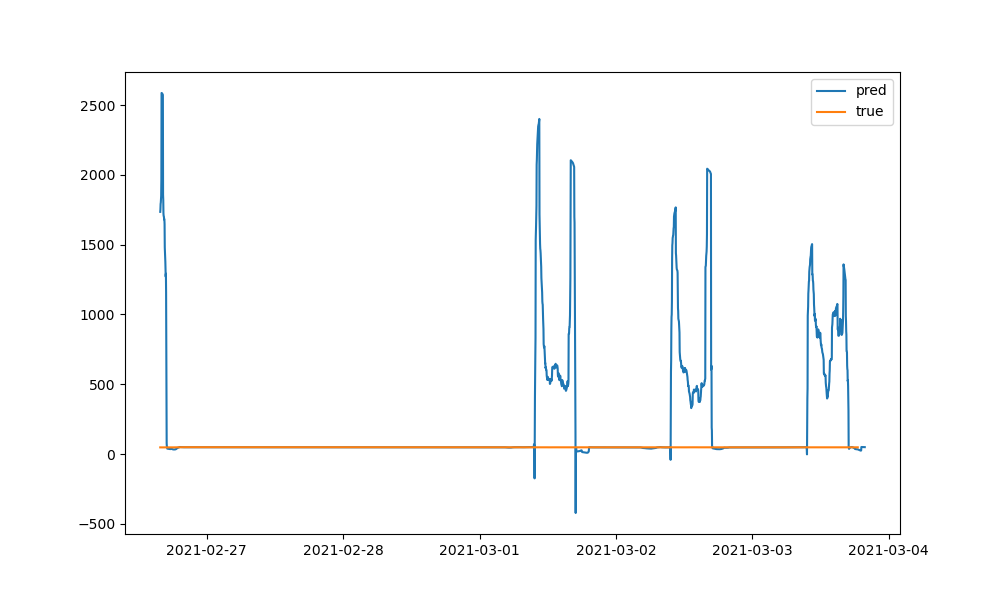

<function matplotlib.pyplot.show(block=None)>

In [127]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 6]

plt.plot(test_dates_list, de_normed_y_hat)
plt.plot(test_dates_list, test_close_vals)
plt.legend(['pred','true'])
plt.show

In [ ]:
these_params = clfrbf.get_params()

In [ ]:
print(these_params)

In [ ]:
import pickle
# this methodology works for saving a trained model
pickle.dump(clfrbf, open("test.model", "wb"))

In [ ]:
import joblib as joblib
from joblib import dump
filename = "test.joblib"
joblib.dump(clfrbf, filename)

In [ ]:
import dill

with open("test", "wb") as dill_file:
    dill.dump(clfrbf, dill_file)

In [ ]:
this_save = dill.dumps(clfrbf) 

In [ ]:
this_load = pd.read_pickle(r'test.model')

In [ ]:
y_hat = this_load.predict(X_test)

In [ ]:
with open("test.model", "wb") as dill_file:
    dill.dump(this_save, dill_file)

In [ ]:
this_open = dill.load("test.model") 

In [ ]:
#with open("test.model", "rb") as dill_file:
    test_clf = dill.load(this_open)

In [ ]:
y_hat_descaled['adj_close']

In [130]:
y_hat_train.shape

(11784,)

In [131]:
pd.DataFrame(norms).shape

(11604, 1)

In [134]:
de_normed_y_hat = y_hat_train[slow+90:] * norms

<IPython.core.display.Javascript object>


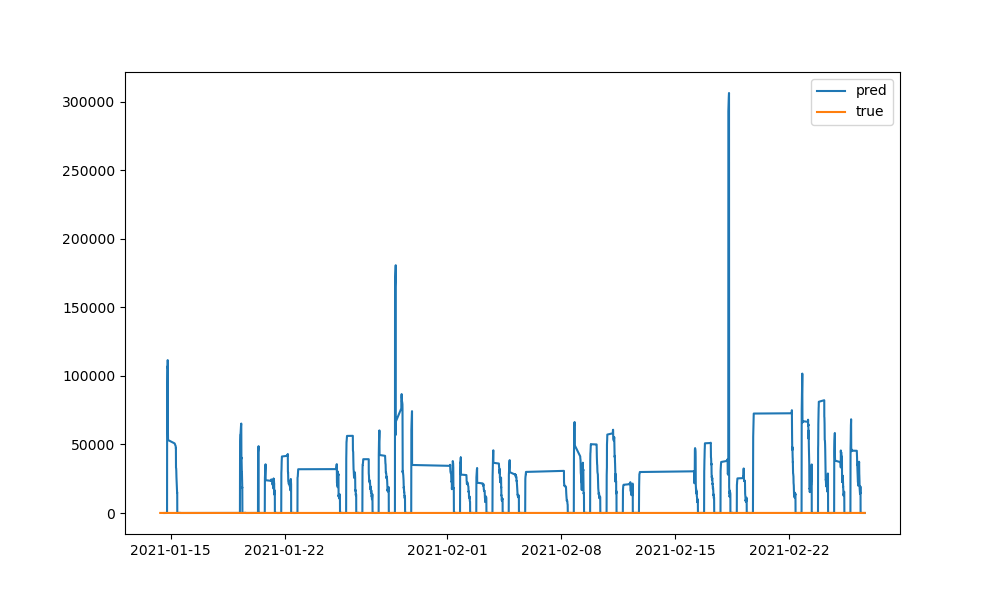

<function matplotlib.pyplot.show(block=None)>

In [139]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 6]

plt.plot(train_dates_list[slow+180:], de_normed_y_hat)
plt.plot(train_dates_list[slow:], train_close_vals[slow:])
plt.legend(['pred','true'])
plt.show